In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc, animation
from IPython.display import HTML, display, Image
import pandas as pd
import math
%matplotlib inline

In [2]:
df = pd.read_csv('energy_demand.txt')

In [3]:
df.head()

,C,NEMP.WORLD,LFCST_HISTDEMAND,AEMO,PUBLIC,2018/12/02,02:00:00,0000000301717790,Unnamed: 8,0000000301717789
0,I,DEMAND,HISTORIC,1,REGIONID,SETTLEMENTDATE,PERIODID,DEMAND,NaN,NaN
1,D,DEMAND,HISTORIC,1,NSW1,2018/12/01 00:00:00,1,7083,NaN,NaN
2,D,DEMAND,HISTORIC,1,NSW1,2018/12/01 00:00:00,2,6858,NaN,NaN
3,D,DEMAND,HISTORIC,1,NSW1,2018/12/01 00:00:00,3,6600,NaN,NaN
4,D,DEMAND,HISTORIC,1,NSW1,2018/12/01 00:00:00,4,6354,NaN,NaN


In [4]:
df = df.drop([df.columns[0],df.columns[1],df.columns[2],df.columns[3],df.columns[-2], df.columns[-1]], axis='columns')

In [5]:
df.head()

,PUBLIC,2018/12/02,02:00:00,0000000301717790
0,REGIONID,SETTLEMENTDATE,PERIODID,DEMAND
1,NSW1,2018/12/01 00:00:00,1,7083
2,NSW1,2018/12/01 00:00:00,2,6858
3,NSW1,2018/12/01 00:00:00,3,6600
4,NSW1,2018/12/01 00:00:00,4,6354


In [6]:
df = df.rename(columns={'PUBLIC':'REGION', '2018/12/02':'DATE', '02:00:00':'PERIOD_ID', '0000000301717790':'MW'})

In [7]:
# quickly check if anything looks out of place
print(pd.unique(df['REGION']))
print(pd.unique(df['DATE']))
print(pd.unique(df['PERIOD_ID']))
print(pd.unique(df['MW']))

['REGIONID' 'NSW1' 'QLD1' 'SA1' 'TAS1' 'VIC1' nan 'PUBLIC']
['SETTLEMENTDATE' '2018/12/01 00:00:00' nan '2018/12/03'
 '2018/12/02 00:00:00' '2018/12/04' '2018/12/03 00:00:00' '2018/12/05'
 '2018/12/04 00:00:00' '2018/12/06' '2018/12/05 00:00:00' '2018/12/07'
 '2018/12/06 00:00:00' '2018/12/08' '2018/12/07 00:00:00' '2018/12/09'
 '2018/12/08 00:00:00' '2018/12/10' '2018/12/09 00:00:00' '2018/12/11'
 '2018/12/10 00:00:00' '2018/12/12' '2018/12/11 00:00:00' '2018/12/13'
 '2018/12/12 00:00:00' '2018/12/14' '2018/12/13 00:00:00' '2018/12/15'
 '2018/12/14 00:00:00' '2018/12/16' '2018/12/15 00:00:00' '2018/12/17'
 '2018/12/16 00:00:00' '2018/12/18' '2018/12/17 00:00:00' '2018/12/19'
 '2018/12/18 00:00:00' '2018/12/20' '2018/12/19 00:00:00' '2018/12/21'
 '2018/12/20 00:00:00' '2018/12/22' '2018/12/21 00:00:00' '2018/12/23'
 '2018/12/22 00:00:00' '2018/12/24' '2018/12/23 00:00:00' '2018/12/25'
 '2018/12/24 00:00:00' '2018/12/26' '2018/12/25 00:00:00' '2018/12/27'
 '2018/12/26 00:00:00' '2018/12

In [8]:
len(df)

96227

In [9]:
# remove dirty rows
df = df[df.REGION != 'REGION']
df = df[df.REGION != 'PUBLIC']
df = df[df.PERIOD_ID != 'PERIODID']
df = df[df.MW != 'DEMAND']

df = df.dropna()

In [10]:
len(df)

95040

In [11]:
# convert columns from str to int
df['PERIOD_ID'] = df['PERIOD_ID'].astype(int)
df['PERIOD_ID'] = df['PERIOD_ID']/2
df['MW'] = df['MW'].astype(int)

In [12]:
# convert DATE from str to DATETIME
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y/%m/%d %H:%M:%S')

In [13]:
# split into state df
NSW = df.loc[df['REGION'] == 'NSW1']
QLD = df.loc[df['REGION'] == 'QLD1']
SA = df.loc[df['REGION'] == 'SA1']
TAS = df.loc[df['REGION'] == 'TAS1']
VIC = df.loc[df['REGION'] == 'VIC1']

In [14]:
# sort by date and period
NSW = NSW.sort_values(by=['DATE', 'PERIOD_ID'])
QLD = QLD.sort_values(by=['DATE', 'PERIOD_ID'])
SA = SA.sort_values(by=['DATE', 'PERIOD_ID'])
TAS = TAS.sort_values(by=['DATE', 'PERIOD_ID'])
VIC = VIC.sort_values(by=['DATE', 'PERIOD_ID'])

In [15]:
vic_days = []
days = pd.unique(VIC['DATE'])
for d in days:
    da = VIC.loc[VIC['DATE']== d]
    vic_days.append(da)

In [16]:
# day interval 
t = vic_days[0]['PERIOD_ID']

In [17]:
vic_usage_daily = []
for day in vic_days:
    d = day['MW']
    vic_usage_daily.append(d)

In [18]:
def init():
    line.set_data([],[])

In [19]:
def animate(i):
    x = t
    y = vic_usage_daily[i]
    line.set_xdata(x)
    line.set_ydata(y)
    return line,

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


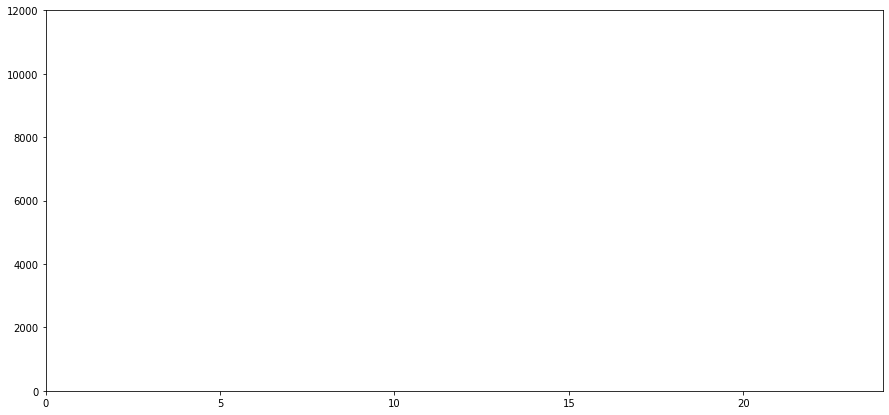

In [20]:
fig = plt.figure(figsize=(15,7))
ax = plt.subplot(111)
ax.set_ylim((0,12000))
ax.set_xlim((0,24))
line, = ax.plot([],[])
anim = animation.FuncAnimation(fig, func=animate, frames=len(t), interval=500, init_func=init)
anim.save('energy.gif')

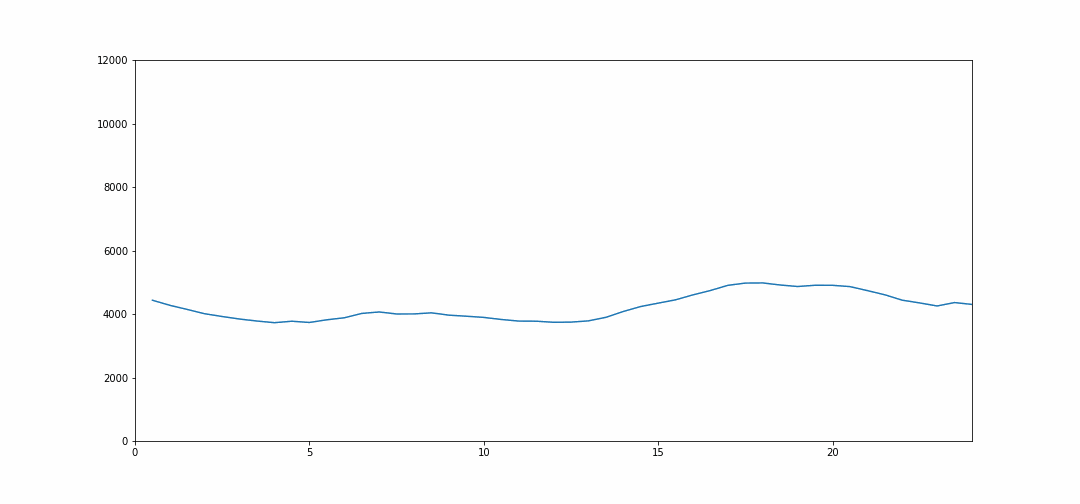

In [21]:
with open('energy.gif', 'rb') as gif:
    display(Image(gif.read()))

In [22]:
sun_times = open('sunrise_sunset_times.txt', 'r', encoding='utf-8').read()

In [23]:
sun_times = sun_times.splitlines()

In [24]:
import re

In [25]:
def times_strip(row):
    times = row[2:25] # splice first part of string
    times = re.findall(r'\d:\d\d', times) # find times
    srise, sset = times[0], times[1] # assign variables
    srise, sset = srise.split(':'), sset.split(':') # split into hours and minutes
    srise = list(map(int, srise)) # convert all numbers from str to int
    sset = list(map(int, sset)) # convert all numbers from str to int
    srise[1] = srise[1]/60 # covert minutes to hours
    sset[0], sset[1] = sset[0]+12, sset[1]/60 # convert hours to 24 time, minutes to hours
    srise, sset = sum(srise), sum(sset) # sum each time into one
    return srise, sset

In [26]:
'''
for each day on the year, strip the sunrise and sunset times, 
convert to 24 decimal time and add to year_times list
'''
year_times = []
for row in sun_times:
    if len(row) != 0:
        day_times = times_strip(row)
        year_times.append(day_times)

In [27]:
len(year_times) == len(vic_days) # check if number of sunrise/sunset times match number of energy demand records

True

### First we need to determine the amount of energy needed to run the state between sunset and sunrise. 